In [3]:
from Utilities.ExpModels import ArchModel
import numpy as np
from scipy.integrate import quad, dblquad
import matplotlib.pyplot as plt

In [4]:
#Get this code into a usabel form for a single observed data point.

In [5]:
class ARCH_TP:
    def ret_e(self,theta1):
        T = len(self.x)
        Q = np.identity(T)
        R = np.identity(T-1)*(-theta1)
        Q[1:,:-1] = Q[1:,:-1] + R
        x = self.x.reshape(T,1)
        e = np.dot(Q,x).reshape(T)
        return e

    def val1(self,a,b,theta2):
        return (np.exp(-np.power(b,2)/(2*(0.2+theta2*np.power(a,2))))/np.sqrt(2*np.pi*(0.2+theta2*np.power(a,2))))

    def val2(self,a):
        return (np.exp(-np.power(a,2)/2)/np.sqrt(2*np.pi))

    def p1_integrand(self,a,b,theta2):
        return self.val1(a,b,theta2)*self.val2(a)

    def p1(self,b,theta2):
        return quad(self.p1_integrand,-np.inf,np.inf,args = (b,theta2))[0]

    def LOGprod_term(self,e,theta2):
        prod = 0
        T=len(self.x)
        for i in range(1,T):
            prod = prod + np.log(self.val1(e[i-1],e[i],theta2))
        return prod

    def LOGprobability(self,theta1,theta2):
        e = self.ret_e(theta1)
        return np.log(self.p1(e[0],theta2)) + self.LOGprod_term(e,theta2)

    def LOGnumerator(self,thetas):
        [theta1,theta2] =thetas
        return self.LOGprobability(theta1,theta2)
    
    def denominator_integrand(self,c,theta1,theta2):
        return np.exp(self.LOGnumerator([theta1,theta2]) - c)

    def LOGdenominator(self,c):
        return c + np.log(dblquad(lambda theta1,theta2: self.denominator_integrand(c,theta1,theta2),0,1,lambda q: -1,lambda q: 1)[0])

    def truePosterior(self,observed_data,theta_values):
        self.x =observed_data
        LogLik = np.apply_along_axis(self.LOGnumerator, 1, theta_values)
        c = np.max(LogLik)
        denom = self.LOGdenominator(c)
        return np.exp(LogLik-denom)
    
    def visualize(self,theta1,theta2,post):
        #theta1 is xv from meshgrid
        #theta2 is yv from meshgrid
        plt.figure()
        plt.clf()
        postReshape = post.reshape(theta1.shape)
        CS = plt.contour(theta1, theta2, postReshape)
        plt.clabel(CS, inline=1, fontsize=10)
        plt.title('Arch True Posterior')
        plt.show()

In [8]:
#Model and observed data.
model = ArchModel(-1,1, 0,1) 
theta1 = 0.3
theta2 = 0.3
x = model.GeneratorThetaGiven([theta1,theta2],1)[0]*10
# values at which to compute the posterior
theta1_values=np.linspace(-0.9,0.9 , 10)
theta2_values=np.linspace( 0.1,0.9 , 10)
xv,yv = np.meshgrid(theta1_values,theta2_values)
theta_vals = np.dstack((xv,yv))
theta_values = theta_vals.reshape(100,2)

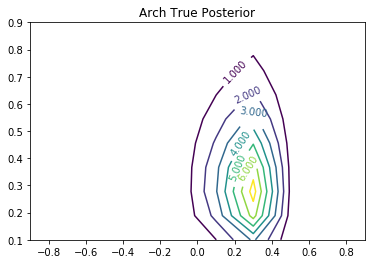

In [9]:
#Calculate true posterior
obj = ARCH_TP()
post = obj.truePosterior(x,theta_values)
obj.visualize(xv,yv,post)